# Basic clustering algorithms and cluster visualization

In [4]:
import pandas as pd

# Import Bedretto M0 experiment provisional dataset 
catalog = pd.read_csv('seiscomp-exp-dd_20240415.csv')
catalog_xyz = catalog[['x', 'y', 'z']]

In [227]:
len(catalog)

8013

## RANSAC 

In [93]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.spatial import ConvexHull

In [94]:
# RANSAC to detect planes
def fit_ransac_planes(X, max_planes=3, residual_threshold=0.1):
    inliers = np.full(X.shape[0], -1, dtype=int)  # Initialize with -1 for noise
    plane_labels = 0
    remaining_points = np.arange(X.shape[0])

    while plane_labels < max_planes and len(remaining_points) > 0:
        ransac = RANSACRegressor(residual_threshold=residual_threshold)
        X_subset = X[remaining_points]
        ransac.fit(X_subset[:, :2], X_subset[:, 2])
        inlier_mask = ransac.inlier_mask_
        
        if np.sum(inlier_mask) == 0:
            break
        
        inliers[remaining_points[inlier_mask]] = plane_labels
        remaining_points = remaining_points[~inlier_mask]
        plane_labels += 1
    
    return inliers

In [101]:
# Fit planes
inliers = fit_ransac_planes(X_orth, max_planes=10, residual_threshold = 1)

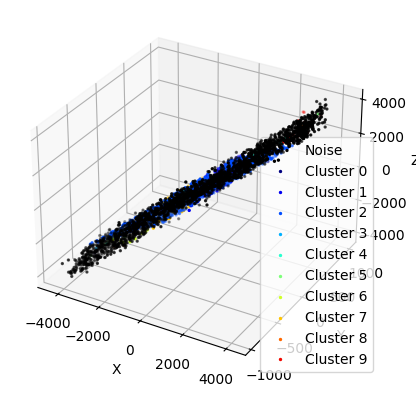

In [102]:
# Plot results
def plot_3d(X_orth, inliers):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define colors
    unique_labels = np.unique(inliers)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

    for label in unique_labels:
        if label == -1:
            color = 'k'  # Black for outliers
        else:
            color = colors[label]
        ax.scatter(X_orth[inliers == label, 0], X_orth[inliers == label, 1], X_orth[inliers == label, 2], 
                   color=color, label=f'Cluster {label}' if label != -1 else 'Noise', s=2)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

plot_3d(X_orth, inliers)

In [99]:
from sklearn.metrics import adjusted_rand_score

def compute_adjusted_rand_index(ground_truth_labels, predicted_labels):
    """
    Compute the Adjusted Rand Index (ARI) between ground truth labels and predicted labels.

    Parameters:
    ground_truth_labels (np.ndarray): Ground truth cluster labels.
    predicted_labels (np.ndarray): Cluster labels from clustering algorithm.

    Returns:
    ari_score (float): The Adjusted Rand Index score.
    """
    ari_score = adjusted_rand_score(ground_truth_labels, predicted_labels)
    return ari_score

In [103]:
ari_score = compute_adjusted_rand_index(clusters_orth, inliers)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Adjusted Rand Index (ARI): 0.0555


### RANSAC for X_orth dataset

In [86]:
orth = pd.read_csv('toy-orthogonal.csv')
X_orth = orth[['x', 'y', 'z']].values
clusters_orth = orth['cluster'].values

In [92]:
# retain results
eq,idx_inliers=ransac_plane(X_orth ,threshold = 2, iterations=1000)
inliers=X_orth[idx_inliers]

# filter outliers
mask = np.ones(len(X_orth), dtype=bool)
mask[idx_inliers] = False
outliers=X_orth[mask]

UnboundLocalError: cannot access local variable 'equation' where it is not associated with a value

## DBSCAN 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

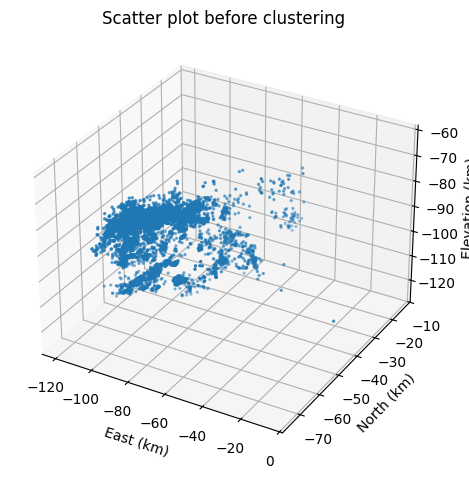

In [292]:
# Plot before clustering algorithm

fig = plt.figure()
ax = plt.axes(projection ="3d")
data = catalog_xyz.to_numpy()
ax.scatter3D(data[:,0], data[:,1], data[:,2], s=2)
plt.title("Scatter plot before clustering")
ax.set_xlabel("East (km)")
ax.set_ylabel("North (km)")
ax.set_zlabel("Elevation (km)")
plt.tight_layout()
plt.show()

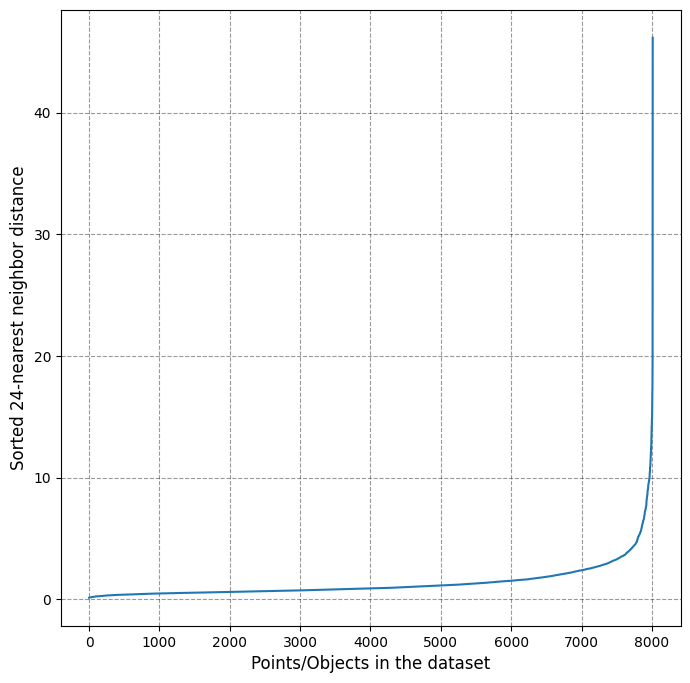

In [193]:
# Choosing the optimal eps parameter value : 
# min pts >= 2*dim(data) 
# eps should be elbow of k-nearest-neighbor distance plot for k=min pts - 1

def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * catalog_xyz.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=catalog_xyz, k=24)

In [294]:
# Run DBSCAN model

model = DBSCAN(eps=2.5, min_samples=30, metric='euclidean')
model.fit_predict(data)
pred = model.fit_predict(data)

In [295]:
labels = model.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 10
Estimated number of noise points: 541


In [296]:
pd.Series(labels).value_counts()

 0    6059
 3     657
-1     541
 4     255
 2     140
 7      88
 1      85
 9      60
 5      50
 8      41
 6      37
Name: count, dtype: int64

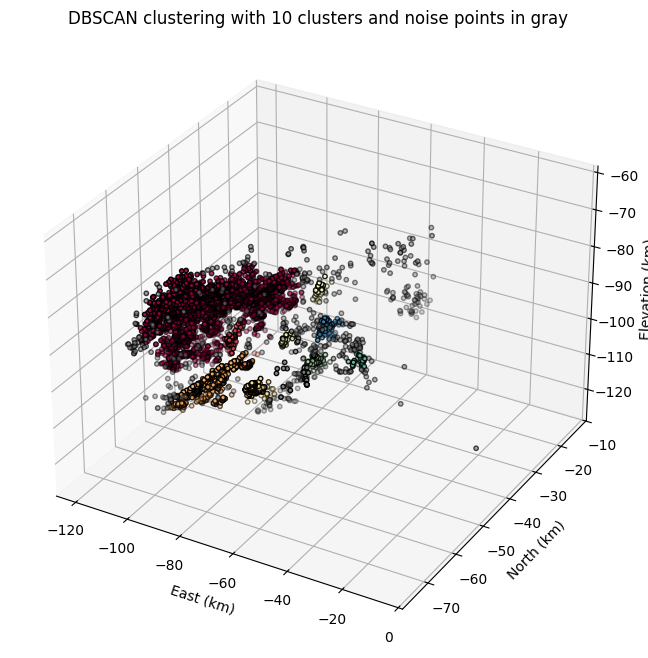

In [324]:
# Unique labels (clusters) and noise
unique_labels = set(labels)

# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Colors: using a colormap
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Gray used for noise.
        col = [0.5, 0.5, 0.5, 1]

    class_member_mask = (labels == k)
    xyz = data[class_member_mask]
    
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], marker='o', edgecolor='k', s=10)

ax.set_title(f"DBSCAN clustering with {n_clusters_} clusters and noise points in gray")
ax.set_xlabel("East (km)")
ax.set_ylabel("North (km)")
ax.set_zlabel("Elevation (km)")
plt.show()

In [325]:
# Dictionary to hold cluster points
clusters = {}
for k in unique_labels:
    class_member_mask = (labels == k)
    clusters[k] = data[class_member_mask]

# Save clusters to files
for k in unique_labels:
    if k == -1:
        # Save noise points
        np.save(f'noise_points.npy', clusters[k])
    else:
        # Save cluster points
        np.save(f'cluster_{k}.npy', clusters[k])

# Example of how to load the data back
# noise_points = np.load('noise_points.npy')
# cluster_0 = np.load('cluster_0.npy')
# cluster_1 = np.load('cluster_1.npy')
# and so on...

## PCA

In [326]:
from sklearn.decomposition import PCA

### PCA for DBSCAN clusters

In [331]:
# Identify the two largest clusters
largest_clusters = sorted(clusters.keys(), key=lambda k: len(clusters[k]), reverse=True)[:2]

# Perform PCA on the two largest clusters
pca_results = {}
planes = {}
for k in largest_clusters:
    pca = PCA(n_components=2)
    pca_results[k] = pca.fit_transform(clusters[k])
    planes[k] = pca.components_

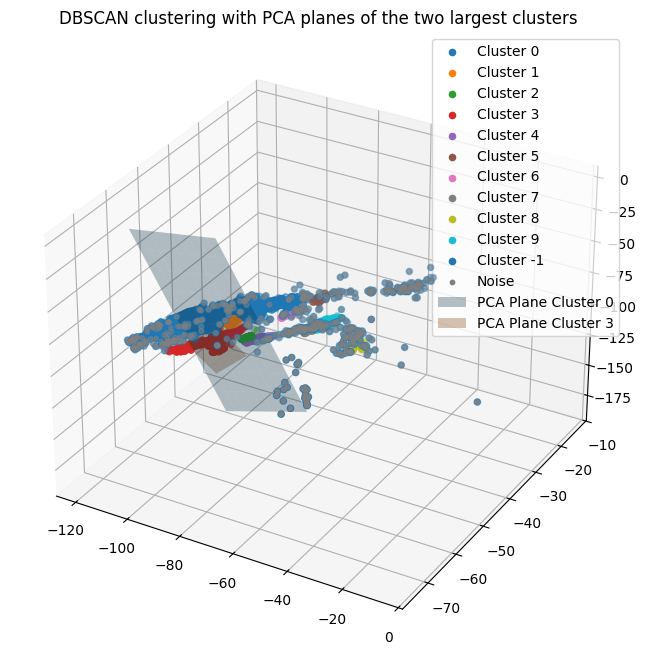

In [334]:
# Create the plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original data
for k in unique_labels:
    xyz = clusters[k]
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], label=f'Cluster {k}', s=20)

# Plot noise points
noise_points = data[labels == -1]
ax.scatter(noise_points[:, 0], noise_points[:, 1], noise_points[:, 2], c='gray', label='Noise', s=10)

# Plot PCA planes
for k in largest_clusters:
    cluster_points = clusters[k]
    centroid = np.mean(cluster_points, axis=0)
    xx, yy = np.meshgrid(np.linspace(np.min(cluster_points[:, 0]), np.max(cluster_points[:, 0]), 10),
                         np.linspace(np.min(cluster_points[:, 1]), np.max(cluster_points[:, 1]), 10))
    zz = (-(planes[k][0, 0] * (xx - centroid[0]) + planes[k][0, 1] * (yy - centroid[1])) / planes[k][0, 2]) + centroid[2]
    ax.plot_surface(xx, yy, zz, alpha=0.3, label=f'PCA Plane Cluster {k}')

ax.set_title('DBSCAN clustering with PCA planes of the two largest clusters')
ax.legend()
plt.show()


## Vertical profiles

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [8]:
# Function to define a certain number of evenly spaced parallel planes (i.e. vertical profiles) governed by strike and dip angles 
# Input : starting point of southern most profile, strike, dip, length (for plot), depth (for plot), distance between profiles,
#         length accross which profile starting points are distributed
# Output : a set of planes onto which the data can be 'projected' for vizualisation
#          If plot=True, the function outputs  a 3D plot of the start and end points of each profile connected by a line

def get_set_of_profiles(profiles, plt):
    # Compute starting points of all profiles
    # Strike angle is measured relative to north, so adjustment of 90° giveds the angle
    # relative to the x-axis.
    # z coordinates remain unchanged (array filled with the value profiles['z0'])
    ww = np.arange(0, profiles['wmax'] + profiles['dw'], profiles['dw'])
    profiles['x0'] = profiles['x0'] + ww * np.cos(np.radians(profiles['strike'] - 90)) 
    profiles['y0'] = profiles['y0'] + ww * np.sin(np.radians(profiles['strike'] - 90))
    profiles['z0'] = profiles['z0'] * np.ones_like(profiles['x0'])
    
    # Compute end points of all profiles
    profiles['xE'] = profiles['x0'] + profiles['length'] * np.cos(np.radians(profiles['strike']))
    profiles['yE'] = profiles['y0'] + profiles['length'] * np.sin(np.radians(profiles['strike']))
    profiles['zE'] = profiles['z0']
    
    # Normal vector
    nx = -np.sin(np.radians(profiles['dip'])) * np.sin(np.radians(profiles['strike']))
    ny = np.sin(np.radians(profiles['dip'])) * np.cos(np.radians(profiles['strike']))
    nz = -np.cos(np.radians(profiles['dip']))
    profiles['normal_vector'] = np.array([nx, ny, nz])  #assign normal vect to profiles
    
    # Find d so that plane goes through point P0(x0,y0,z0)
    profiles['d'] = -nx * profiles['x0'] - ny * profiles['y0'] - nz * profiles['z0']
    
    # Profile boundaries
    xmin, xmax = np.min(np.concatenate([profiles['x0'], profiles['xE']])), np.max(np.concatenate([profiles['x0'], profiles['xE']]))
    ymin, ymax = np.min(np.concatenate([profiles['y0'], profiles['yE']])), np.max(np.concatenate([profiles['y0'], profiles['yE']]))
    profiles['xlim'] = [xmin, xmax]
    profiles['ylim'] = [ymin, ymax]
    profiles['llim'] = [0, profiles['length']]
    profiles['zlim'] = [profiles['z0'][0] - profiles['depth'], profiles['z0'][0]]
    
    # Visualize
    if profiles['plotme']:
        mec = 'k'
        nprofiles = len(profiles['x0'])
        tstring = f"{nprofiles} profiles, every {profiles['dw']}m, with strike={profiles['strike']}°"
        
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        plt.title(tstring)
        
        ax.scatter(profiles['x0'], profiles['y0'], profiles['z0'], c='y', edgecolor=mec, s=64, label='Start Points')
        ax.scatter(profiles['xE'], profiles['yE'], profiles['zE'], c='y', edgecolor=mec, s=64, label='End Points')
        
        for i in range(nprofiles):
            ax.plot([profiles['x0'][i], profiles['xE'][i]], 
                    [profiles['y0'][i], profiles['yE'][i]], 
                    [profiles['z0'][i], profiles['zE'][i]], '-k', label='Profile Line' if i == 0 else "")
            
            # Define the plane for each profile
            #num_points = 10
            #x_plane = np.linspace(profiles['x0'][i], profiles['xE'][i], num_points)
            #y_plane = np.linspace(profiles['y0'][i], profiles['yE'][i], num_points)
            #X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
            #Z_plane = profiles['z0'][i] + (nx * (X_plane - profiles['x0'][i]) + ny * (Y_plane - profiles['y0'][i])) / -nz
            
            #ax.plot_surface(X_plane, Y_plane, Z_plane, color='b', alpha=0.5)
        
        ax.set_xlim([profiles['xlim'][0] - 10, profiles['xlim'][1] + 10])
        ax.set_ylim([profiles['ylim'][0] - 10, profiles['ylim'][1] + 10])
        ax.set_zlim(profiles['zlim'])
        
        plt.grid(True)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.show()
    
    return profiles



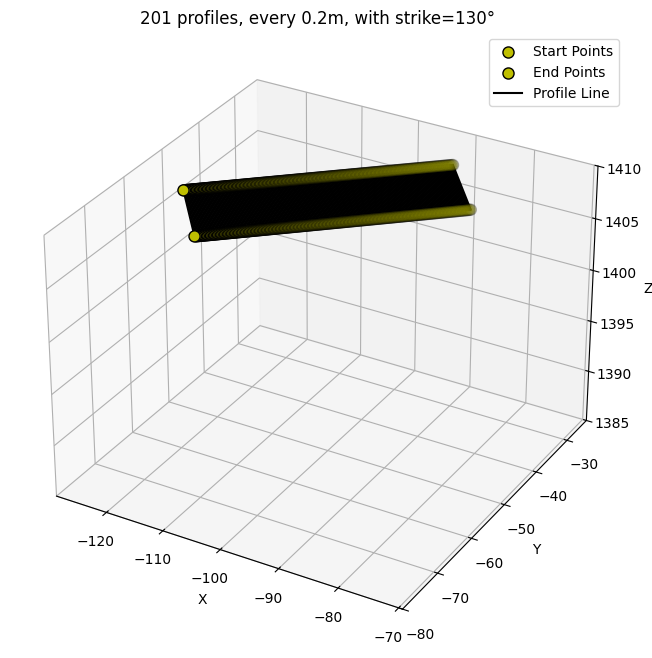

{'x0': array([-110.        , -109.84679111, -109.69358222, -109.54037333,
        -109.38716445, -109.23395556, -109.08074667, -108.92753778,
        -108.77432889, -108.62112   , -108.46791111, -108.31470223,
        -108.16149334, -108.00828445, -107.85507556, -107.70186667,
        -107.54865778, -107.39544889, -107.24224   , -107.08903112,
        -106.93582223, -106.78261334, -106.62940445, -106.47619556,
        -106.32298667, -106.16977778, -106.0165689 , -105.86336001,
        -105.71015112, -105.55694223, -105.40373334, -105.25052445,
        -105.09731556, -104.94410668, -104.79089779, -104.6376889 ,
        -104.48448001, -104.33127112, -104.17806223, -104.02485334,
        -103.87164446, -103.71843557, -103.56522668, -103.41201779,
        -103.2588089 , -103.10560001, -102.95239112, -102.79918223,
        -102.64597335, -102.49276446, -102.33955557, -102.18634668,
        -102.03313779, -101.8799289 , -101.72672001, -101.57351113,
        -101.42030224, -101.26709335, -101

In [9]:
profiles = {    
    'x0' : -110,    # Starting coordinates for southernmost profile
    'y0' : -70,     #  " "
    'z0' : 1410,    # zz = prctile(cat.H, [10 50 90]);
    'strike' : 130,     # Strike of profiles
    'dip' : 90,      # Dip of profiles
    'length' : 14,      # Length [m] of each profile (only relevant for plotting)
    'depth' : 25,      # Depth  [m] of each profile (only relevant for plotting)
    'dw'  : .2,       #Lateral distance [m] between profiles
    'wmax' : 40,      # Length [m] across which profile starting points are distributed
    'plotme'  : True
    }

get_set_of_profiles(profiles, plt)

In [10]:
# Function which projects a 3D point cloud onto a plane (i.e. a specific profile)
# Input : 3D point cloud, profiles info (strike, dip, starting points, etc),
#        index of profile onto which point cloud shoul be projected, plot/no plot
# Ouput : projected 3D coordinates of the points onto the plane, 
#         perpendicular distance between plane and each point,
#         in-plane along-strike distance of each projected point,
#         in-plane along-dip distance of each projected point
#         Graphs: 3D plot of points and plane, 2D profile view of plots projected onto plane 


def project_pointcloud_onto_plane(points, profiles, iprofile, plotme=False):
    # Extract profile parameters
    N = profiles['normal_vector']
    strike = profiles['strike']
    dip = profiles['dip']
    P0 = np.array([profiles['x0'][iprofile], profiles['y0'][iprofile], profiles['z0'][iprofile]])

    npoints = points.shape[0]       # number of points in point cloud (dim npoints x 3)

    P1p = np.zeros((npoints, 3))   # initialize array of projected points
    r = np.zeros(npoints)          # '' array of perpendicular distance between plane and points
    rS = np.zeros(npoints)         # '' array of n-plane along-strike distances
    rD = np.zeros(npoints)         # '' array of in-plane along-dip distances

    for ipoint in range(npoints):
        P1 = points[ipoint, :]    # select ipoint^th row  of array (ipoint^th point)
        V = P1 - P0               # vector (P0, P1)

        # Projection onto fault
        v1 = np.dot(V, N) / np.linalg.norm(N)**2 * N       # component of V parallel to N
        v2 = V - v1         # component of V perpendicular to N =. proj of V onto plane

        # Along-strike vector (vector in strike direction)
        ls = np.linalg.norm(v2)
        s = np.array([ls * np.cos(np.deg2rad(strike)), ls * np.sin(np.deg2rad(strike)), 0])
        s /= np.linalg.norm(s)

        # Along-dip vector 
        dipdir = strike + 90        
        d = np.array([np.cos(np.deg2rad(dip)) * np.cos(np.deg2rad(dipdir)), 
                      np.cos(np.deg2rad(dip)) * np.sin(np.deg2rad(dipdir)), 
                      np.sin(np.deg2rad(dip))])
        d /= np.linalg.norm(d)

        # Projected point
        P1p[ipoint, :] = P0 + v2

        # Fault distances
        r[ipoint] = np.dot(V, N)  # Fault-perpendicular distance
        rS[ipoint] = np.dot(v2, s)  # In-plane along-strike distance
        rD[ipoint] = np.dot(v2, d)  # In-plane along-dip distance

    if plotme:
        fig = plt.figure(figsize=(12, 8))
        
        # 3D scatter plot of the points and the plane
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', label='Original Points')
        ax1.scatter(P1p[:, 0], P1p[:, 1], P1p[:, 2], c='b', marker='^', label='Projected Points')
        
        # Define the plane for visualization
        xx, yy = np.meshgrid(np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), 10),
                             np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), 10))
        zz = (-N[0] * (xx - P0[0]) - N[1] * (yy - P0[1]) - N[2] * P0[2]) / N[2]
        
        ax1.plot_surface(xx, yy, zz, alpha=0.5, rstride=100, cstride=100)
        
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.legend()
        ax1.set_title('3D Projection of Points onto Plane')
        
        # 2D scatter plot of rS vs rD
        ax2 = fig.add_subplot(122)
        sc = ax2.scatter(rS, rD, c=r, cmap='coolwarm')
        plt.colorbar(sc, label='Fault-perpendicular distance [km]')
        ax2.set_xlabel('Along-strike distance [km]')
        ax2.set_ylabel('Along-dip distance [km]')
        ax2.set_title('In-plane Projection')

        plt.tight_layout()
        plt.show()

    return P1p, r, rS, rD

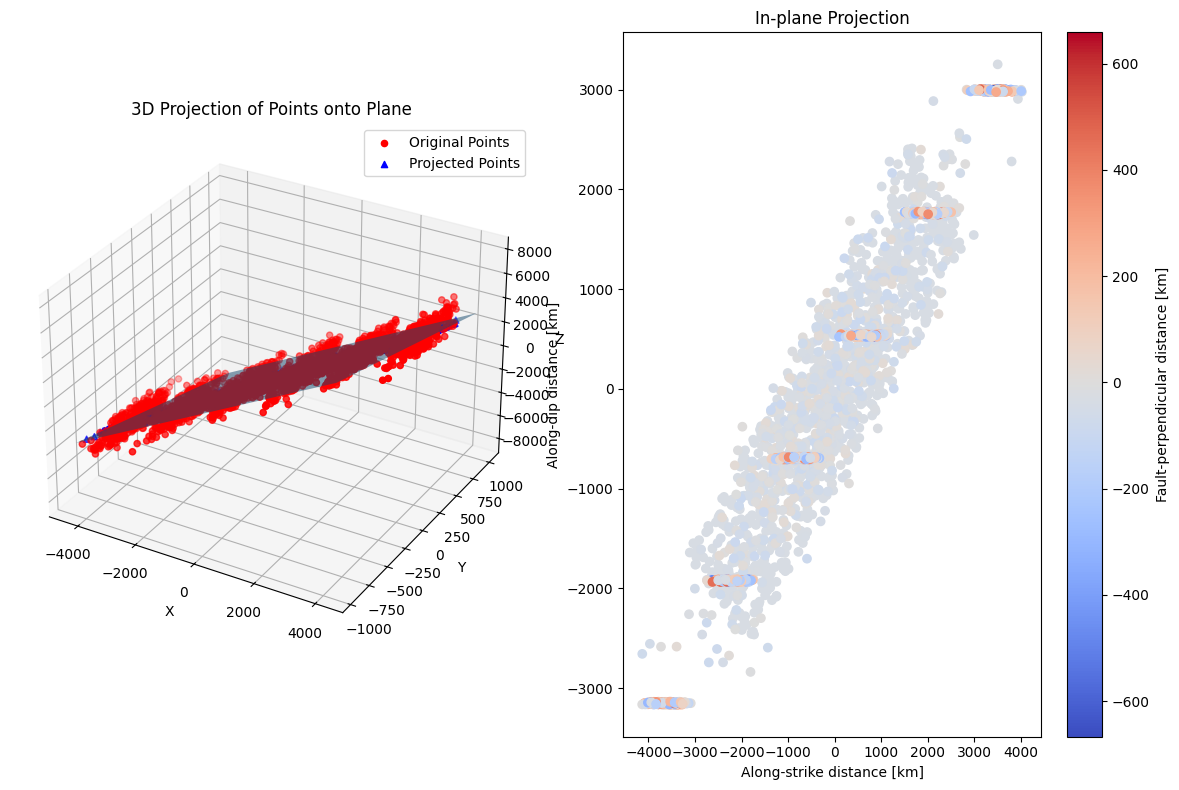

In [21]:
# test on toy dataset 
toy = pd.read_csv('toy-orthogonal.csv')
X_toy = toy[['x', 'y', 'z']].values
clusters_toy = toy['cluster'].values

profiles = {
    'normal_vector': np.array([-0.44115896,  0.82969934,  0.34202014]),
    'strike': 28,
    'dip': 70,
    'x0' : np.array([0,0,0]),
    'y0' : np.array([0,0,0]),
    'z0' : np.array([0,0,0])
}

points = X_toy

iprofile = 0
plotme = True

_, r_main, rS_main, rD_main = project_pointcloud_onto_plane(points, profiles, iprofile, plotme)

In [75]:
import matplotlib.animation as animation

In [76]:
def project_seiscat_onto_set_of_profiles(cat_main, profiles, rmax, plt_options, filename):
    nprofiles = len(profiles['x0'])
    
    if plt_options == 'filmme':
        # Create a figure and an axis for the video
        fig, ax = plt.subplots(figsize=(12, 8))
        writer = animation.FFMpegWriter(fps=2)  # You can adjust the fps (frames per second) as needed

        with writer.saving(fig, f"{filename}.mp4", dpi=300):
            for iprofile in range(nprofiles):
                print(f"Processing profile {iprofile + 1} of {nprofiles}")

                # Find hypocenters of MAIN catalog within rmax of profile
                P1p, r_main, rS_main, rD_main = project_pointcloud_onto_plane(
                    cat_main,
                    profiles,
                    iprofile,
                    False  # We don't need to plot within this function
                )

                # Filter the points based on rmax
                useme = np.abs(r_main) < rmax
                
                cati = cat_main[useme]
                P1p_filtered = P1p[useme]
                rS_main = rS_main[useme]
                rD_main = rD_main[useme]
                rA_main = rD_main + np.unique(profiles['z0'])

                # Determine plot limits based on the data
                x_min, x_max = np.min(rS_main), np.max(rS_main)
                y_min, y_max = np.min(rA_main), np.max(rA_main)

                # Plot profile
                ax.clear()
                ax.grid(True)
                ax.box(True)
                ax.set_aspect('equal')

                # 2D scatter plot of rS vs rD
                sc = ax.scatter(rS_main, rD_main, c=r_main[useme], cmap='coolwarm')
                cbar = plt.colorbar(sc, ax=ax, label='Fault-perpendicular distance [km]')
                ax.set_xlabel('Along-strike distance [km]')
                ax.set_ylabel('Along-dip distance [km]')
                ax.set_title(f'In-plane Projection for Profile {iprofile + 1}')

                # Save frame in video
                writer.grab_frame()

        plt.close()
        print(f"Video saved as {filename}.mp4")
    
    else:
        for iprofile in range(nprofiles):
            print(f"Processing profile {iprofile + 1} of {nprofiles}")

            # Find hypocenters of MAIN catalog within rmax of profile
            P1p, r_main, rS_main, rD_main = project_pointcloud_onto_plane(
                cat_main,
                profiles,
                iprofile,
                False  # We don't need to plot within this function
            )

            # Filter the points based on rmax
            useme = np.abs(r_main) < rmax
            
            cati = cat_main[useme]
            P1p_filtered = P1p[useme]
            rS_main = rS_main[useme]
            rD_main = rD_main[useme]
            rA_main = rD_main + np.unique(profiles['z0'])

            # Determine plot limits based on the data
            x_min, x_max = np.min(rS_main), np.max(rS_main)
            y_min, y_max = np.min(rA_main), np.max(rA_main)

            # Plot profile
            fig = plt.figure(figsize=(12, 8))
            
            # 3D scatter plot of the points and the plane
            ax1 = fig.add_subplot(121, projection='3d')
            ax1.scatter(cati[:, 0], cati[:, 1], cati[:, 2], c='r', marker='o', label='Original Points')
            ax1.scatter(P1p_filtered[:, 0], P1p_filtered[:, 1], P1p_filtered[:, 2], c='b', marker='^', label='Projected Points')
            
            # Define the plane for visualization
            N = profiles['normal_vector']
            P0 = np.array([profiles['x0'][iprofile], profiles['y0'][iprofile], profiles['z0'][iprofile]])
            xx, yy = np.meshgrid(np.linspace(np.min(cati[:, 0]), np.max(cati[:, 0]), 10),
                                 np.linspace(np.min(cati[:, 1]), np.max(cati[:, 1]), 10))
            zz = (-N[0] * (xx - P0[0]) - N[1] * (yy - P0[1]) - N[2] * P0[2]) / N[2]
            
            ax1.plot_surface(xx, yy, zz, alpha=0.5, rstride=100, cstride=100)
            
            ax1.set_xlabel('X')
            ax1.set_ylabel('Y')
            ax1.set_zlabel('Z')
            ax1.legend()
            ax1.set_title('3D Projection of Points onto Plane')
            
            # 2D scatter plot of rS vs rD
            ax2 = fig.add_subplot(122)
            sc = ax2.scatter(rS_main, rD_main, c=r_main[useme], cmap='coolwarm')
            plt.colorbar(sc, label='Fault-perpendicular distance [km]')
            ax2.set_xlabel('Along-strike distance [km]')
            ax2.set_ylabel('Along-dip distance [km]')
            ax2.set_title(f'In-plane Projection for Profile {iprofile + 1}')
            
            plt.tight_layout()
            
            # Save figure
            if plt_options == 'printme':
                plt.savefig(f"{filename}_profile{iprofile + 1}.png", dpi=300)
                plt.close()
            else:
                plt.show()

    print("Processing completed.")

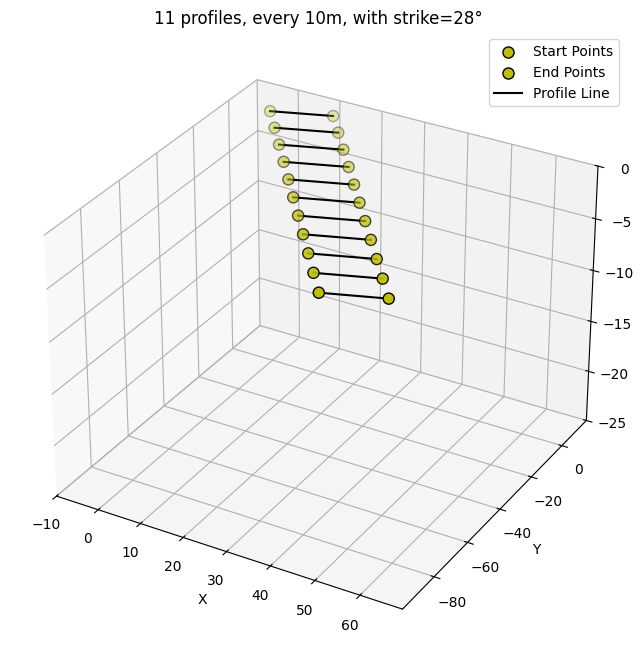

In [82]:
profiles = {    
    'x0' : 0,    # Starting coordinates for southernmost profile
    'y0' : 0,     #  " "
    'z0' : 0,    # zz = prctile(cat.H, [10 50 90]);
    'strike' : 28,     # Strike of profiles
    'dip' : 70,      # Dip of profiles
    'length' : 14,      # Length [m] of each profile (only relevant for plotting)
    'depth' : 25,      # Depth  [m] of each profile (only relevant for plotting)
    'dw'  : 10,       #Lateral distance [m] between profiles
    'wmax' : 100,      # Length [m] across which profile starting points are distributed
    'plotme'  : True
    }

profiles_set = get_set_of_profiles(profiles, plt)

Processing profile 1 of 11


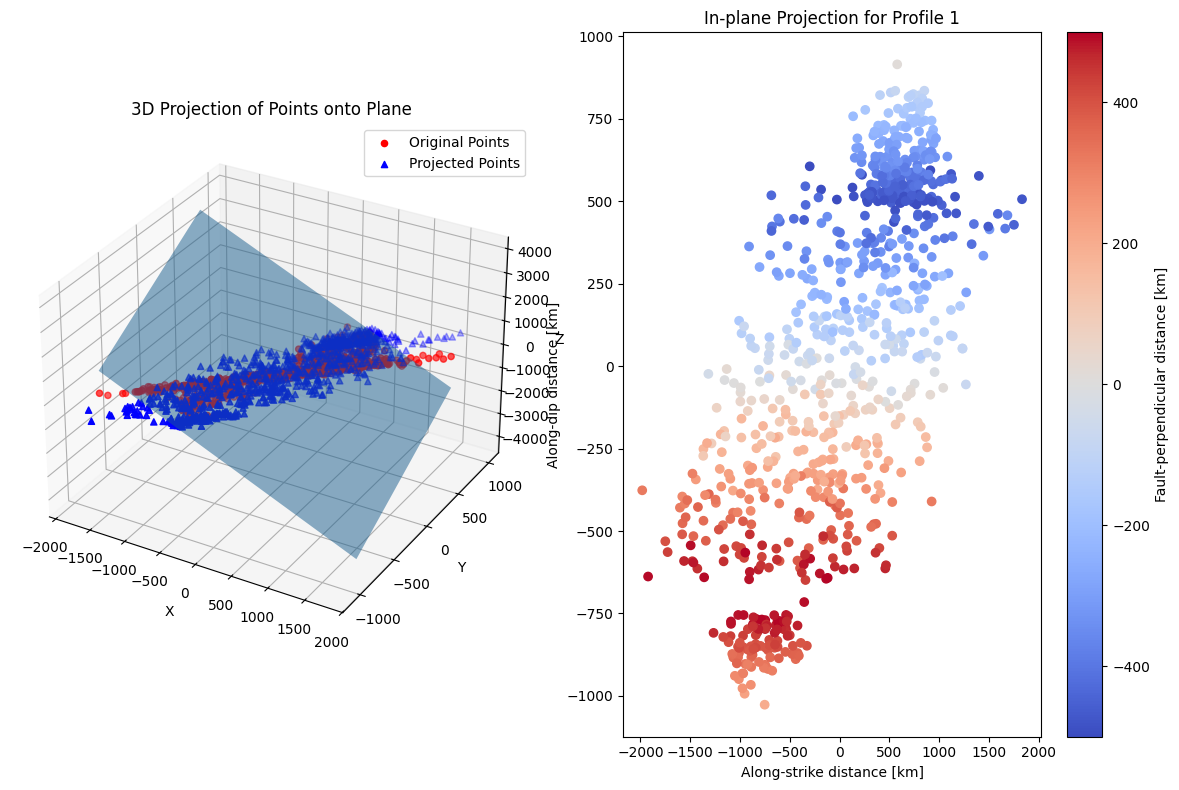

Processing profile 2 of 11


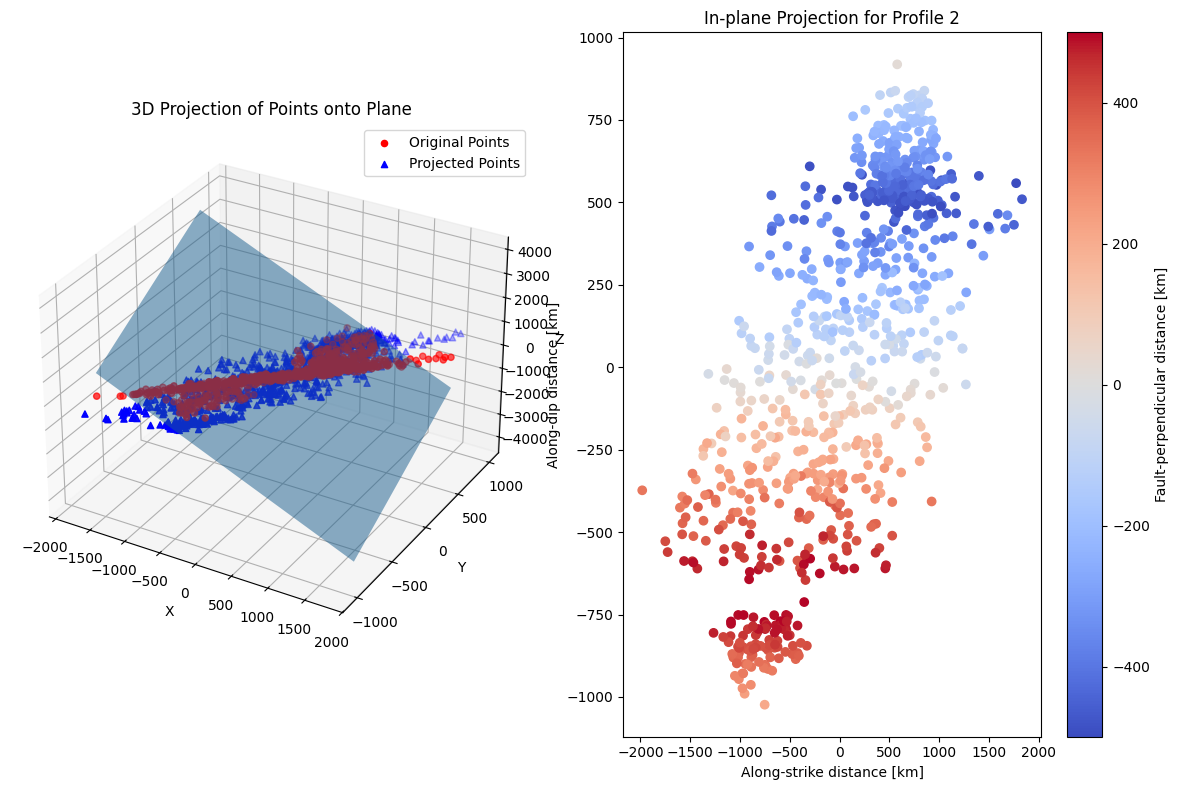

Processing profile 3 of 11


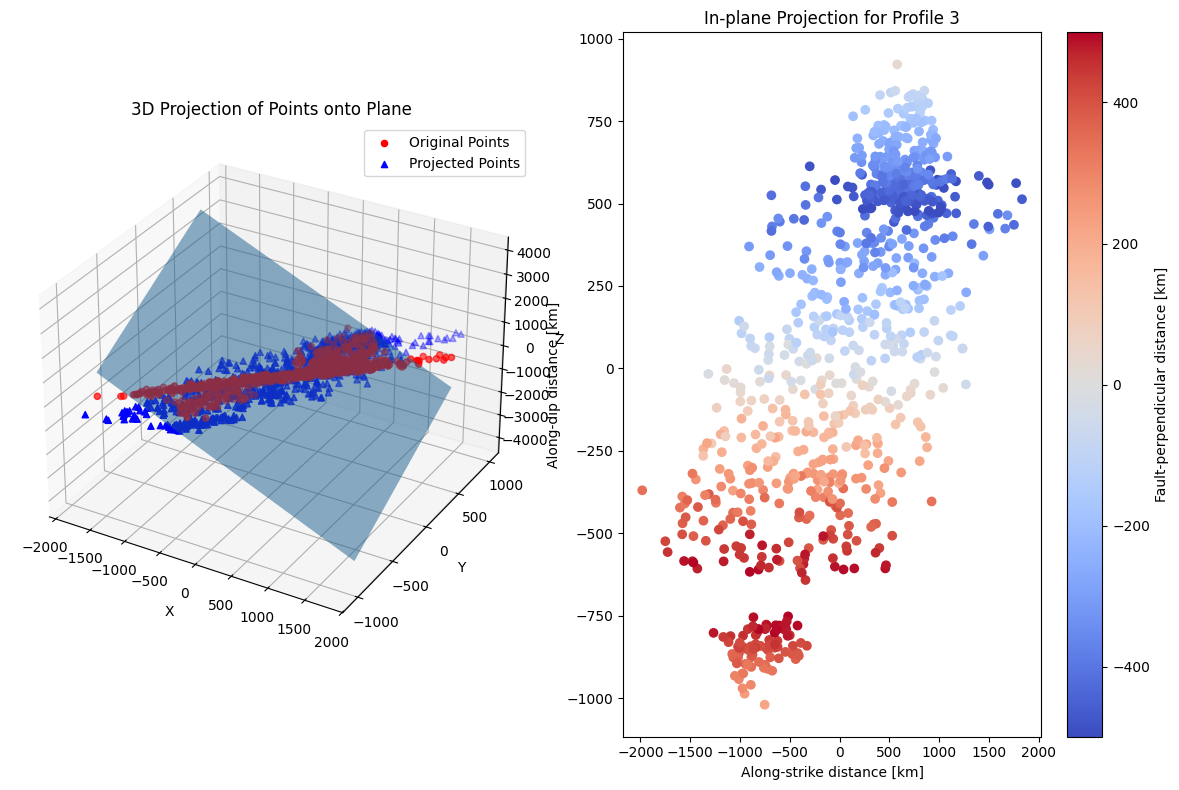

Processing profile 4 of 11


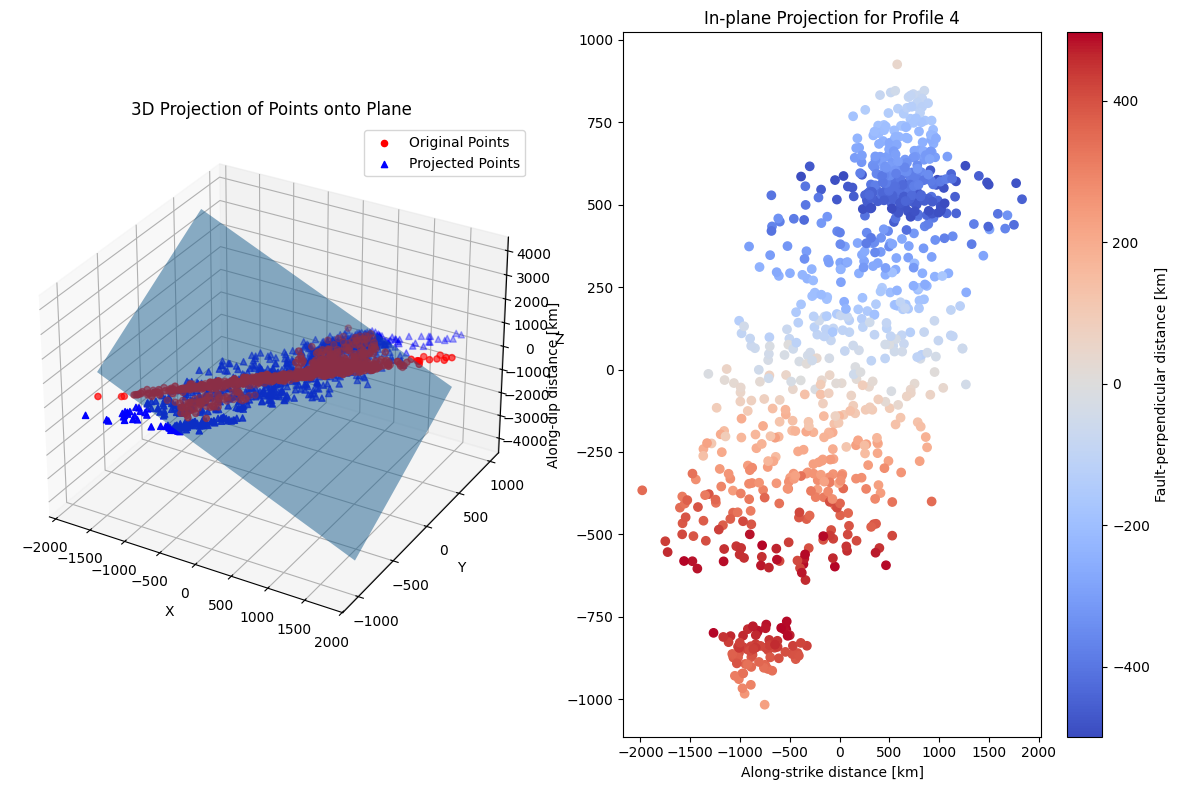

Processing profile 5 of 11


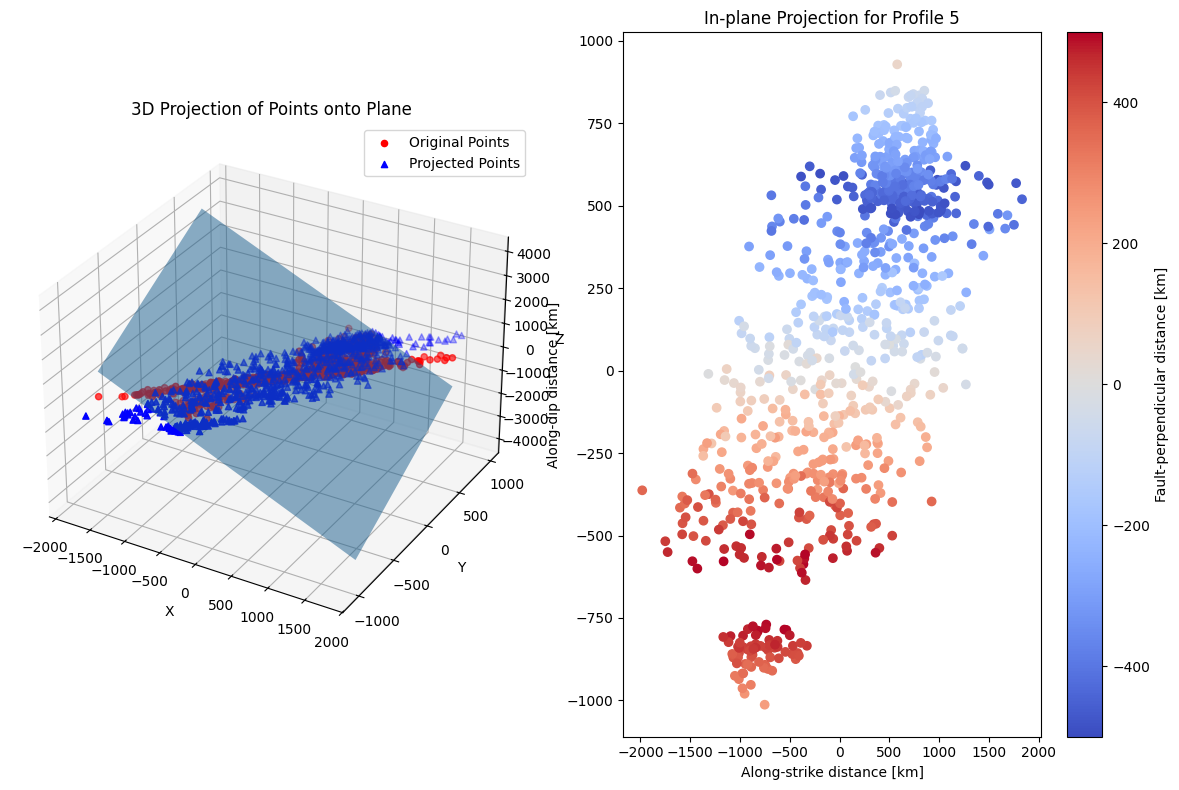

Processing profile 6 of 11


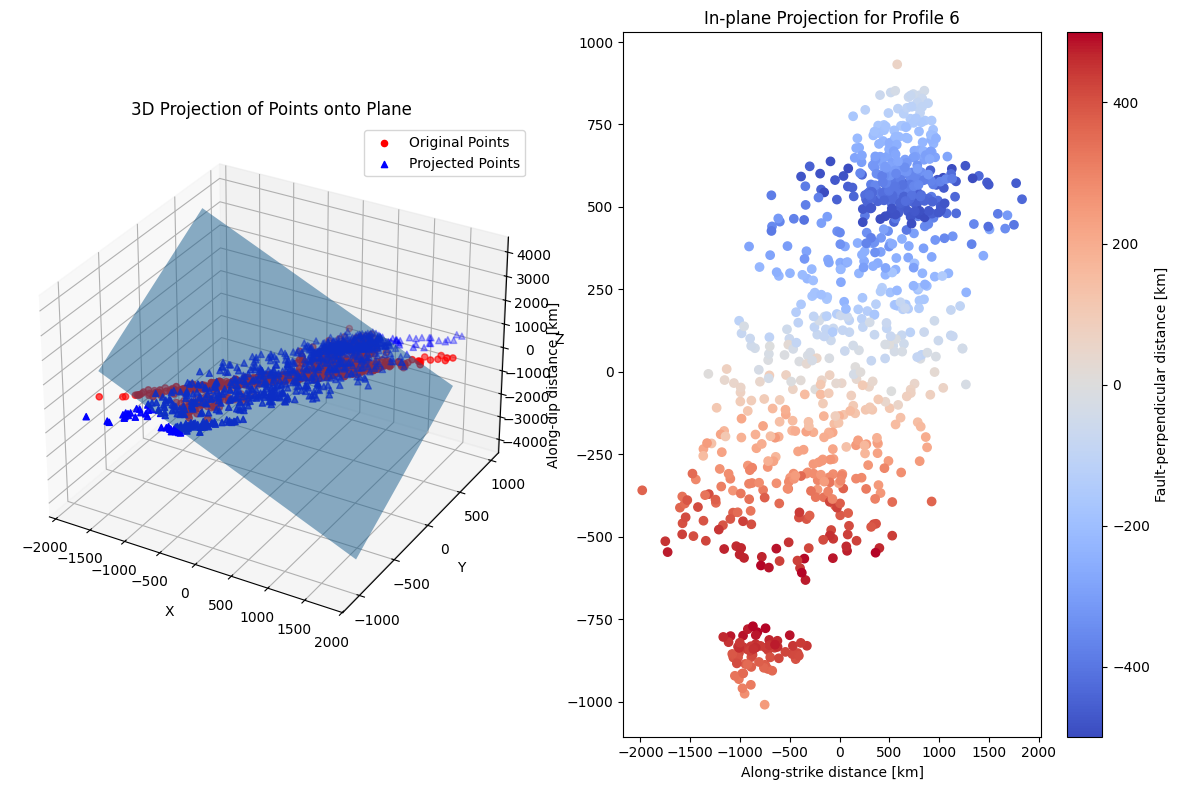

Processing profile 7 of 11


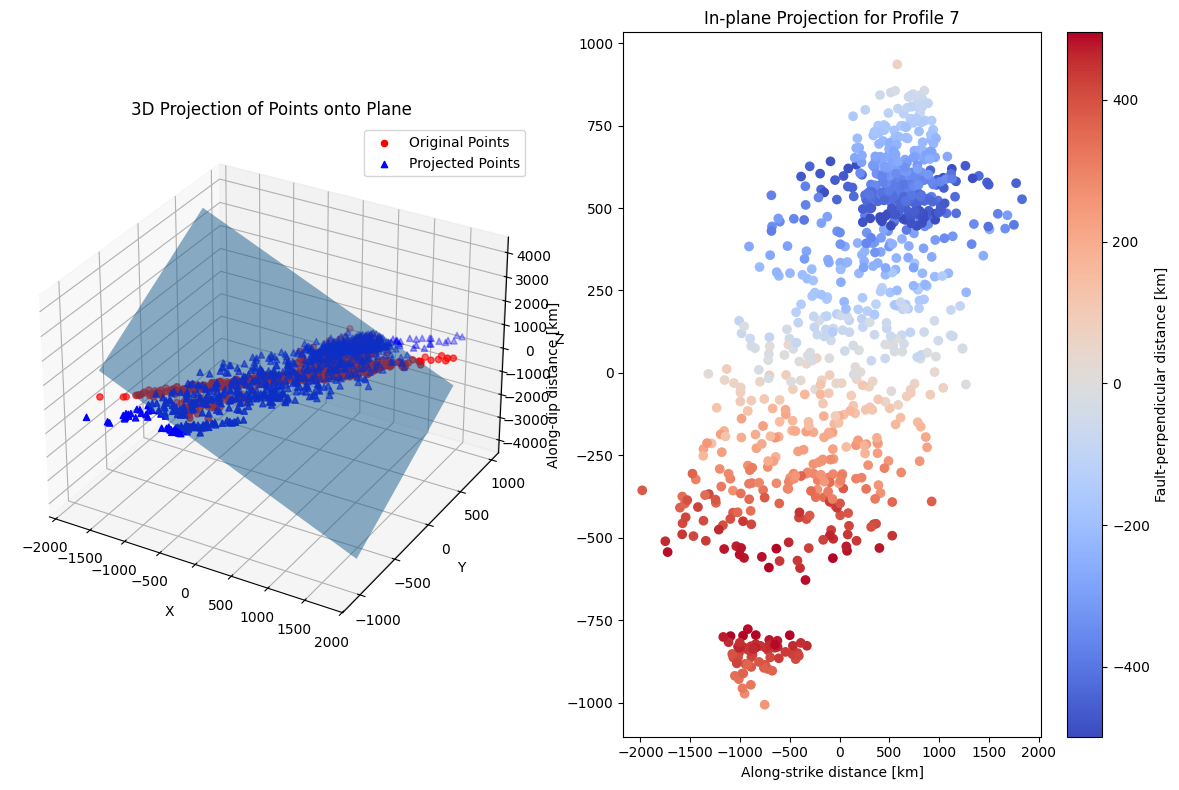

Processing profile 8 of 11


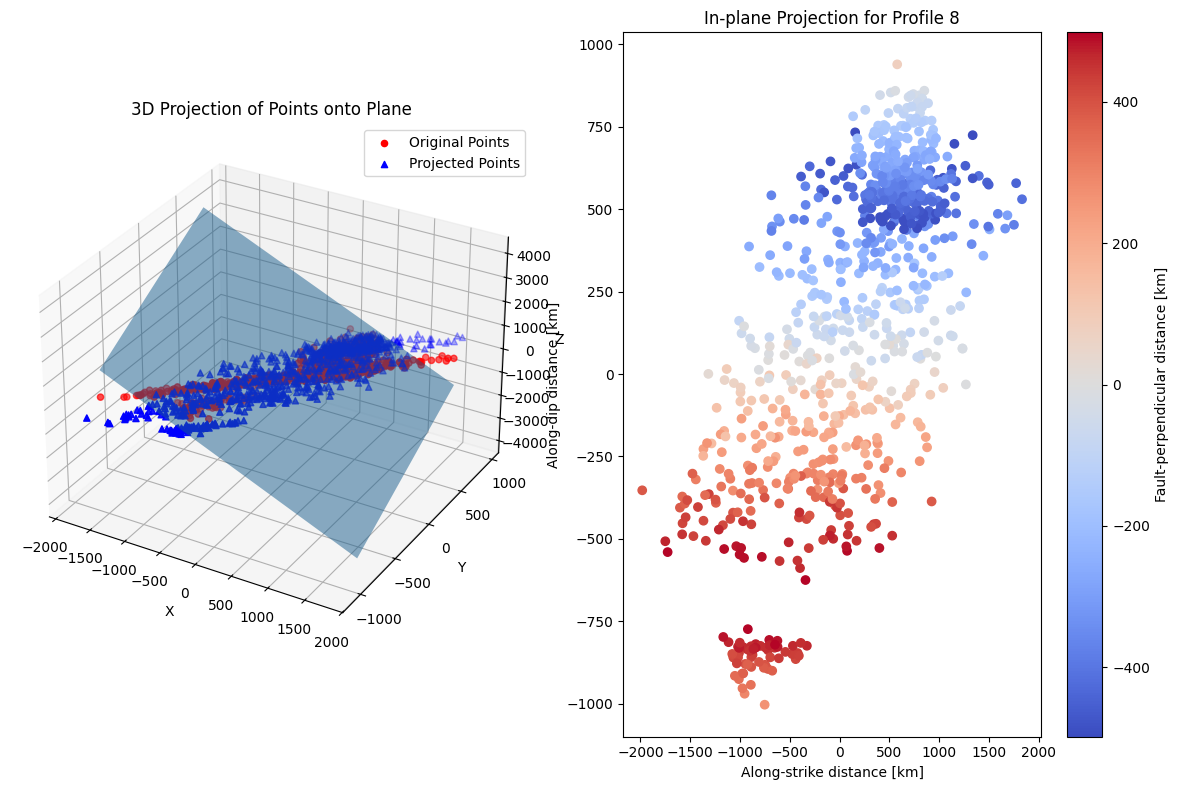

Processing profile 9 of 11


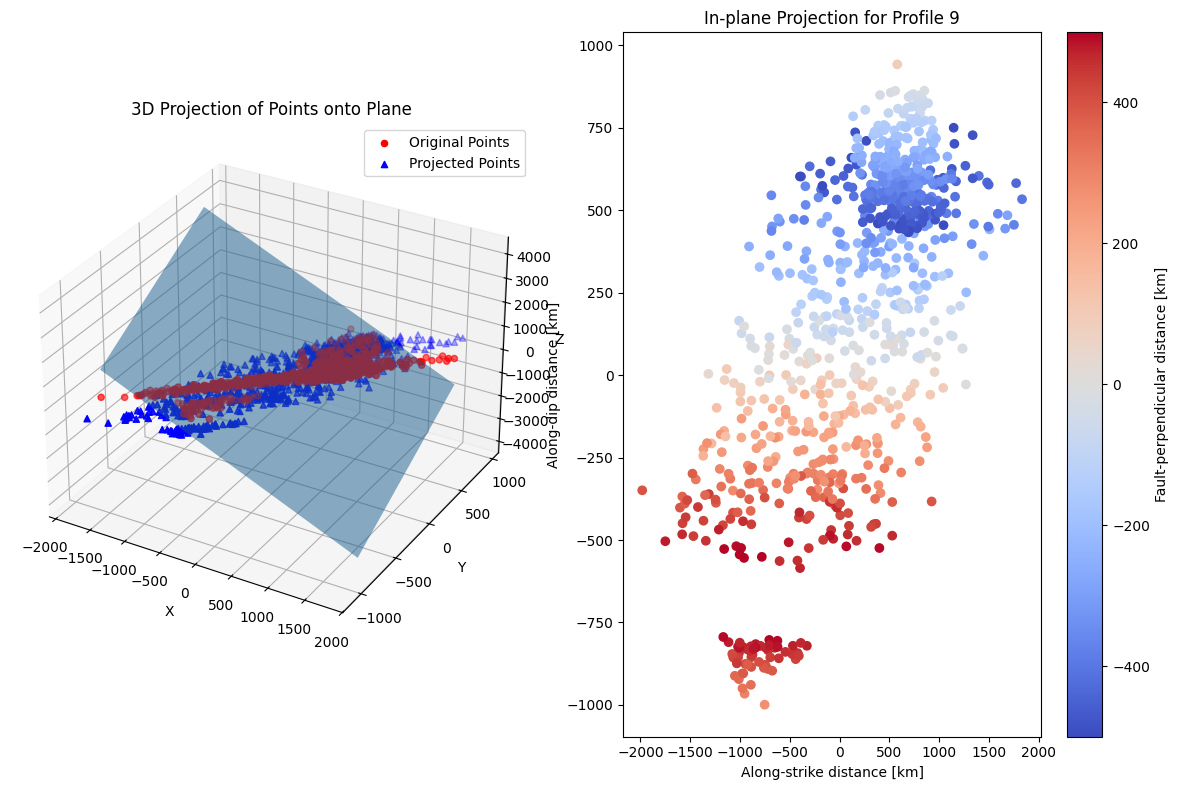

Processing profile 10 of 11


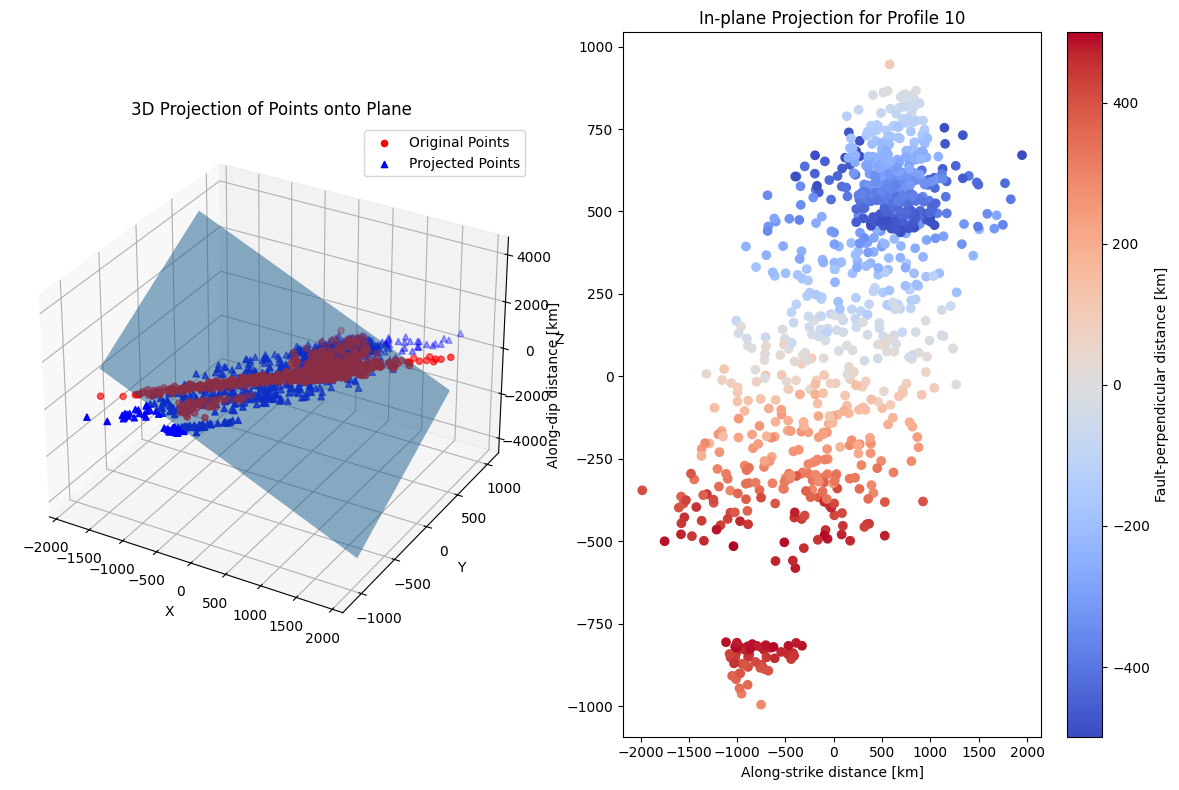

Processing profile 11 of 11


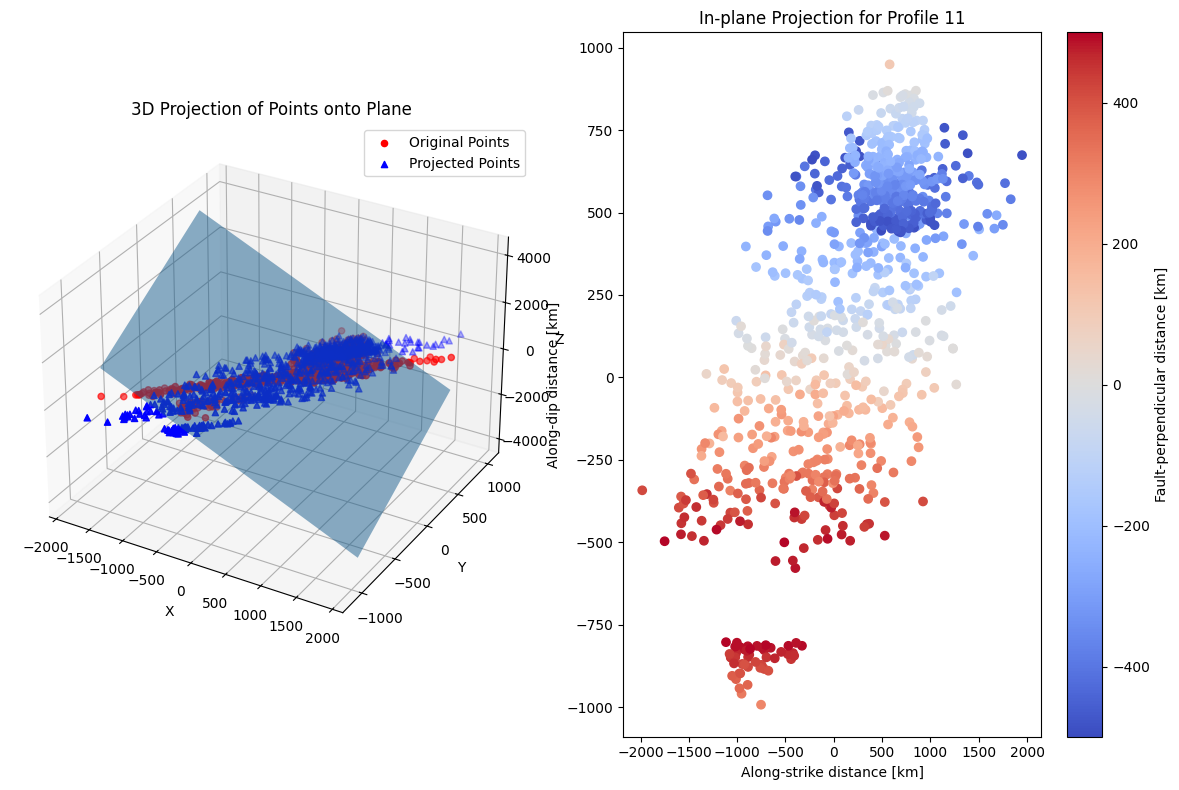

Processing completed.


In [85]:
rmax=500
project_seiscat_onto_set_of_profiles(points, profiles, rmax, plt_options='plotme', filename = 'test')